In [1]:
# --- Robust path setup (works locally, Colab, GitHub) ---
import sys
from pathlib import Path

NB_DIR = Path.cwd()
for cand in [NB_DIR, *NB_DIR.parents]:
    if (cand / "src").exists():
        # add src/ so we can `from utils import ...`
        sys.path.insert(0, str(cand / "src"))
        break

from utils import project_root, data_dir

ROOT = project_root()
DATA = data_dir()

print("Project root:", ROOT)
print("Data dir:", DATA)

# (optional) pin CWD to ROOT so any relative file writes go under the repo
import os
os.chdir(ROOT)
print("CWD pinned to:", Path.cwd())

Project root: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection
Data dir: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/data
CWD pinned to: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection


<h2> PART 1 — LOAD, CHECK, PAIR, SAVE <h2/>

In [32]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

In [14]:


# Paths (repo friendly)
BASE = Path(".")  # project root
AUDIO_CSV  = BASE / "notebooks" / "audio_probs.csv"
VIDEO_CSV  = BASE / "outputs" / "video_priors.csv"
SENSOR_CSV = BASE / "outputs" /"sensor"/ "sensor_probs.csv"
OUT_DIR    = BASE / "outputs" / "fusion_2D_vs_3D"

OUT_DIR.mkdir(parents=True, exist_ok=True)

# Classes 
CLASSES = ["dog", "door_wood_knock", "footsteps", "glassbreak", "gunshot", "siren"]

# Random generator (reproducible)
rng = np.random.default_rng(42)

In [9]:


# 1) Load audio
aud = pd.read_csv(AUDIO_CSV)

# Build expected column names
Acols = [f"audio_{c}" for c in CLASSES]

# Sanity check
assert all(c in aud.columns for c in Acols), f"Missing expected columns in {AUDIO_CSV}"

# Extract features and labels
A = aud[Acols].to_numpy(float)
y = aud["audio_true"].to_numpy(int)

print(f"Audio loaded: A={A.shape}, y={y.shape}")

Audio loaded: A=(144, 6), y=(144,)


In [12]:
# ---- 2) Load video ----
vdf = pd.read_csv(VIDEO_CSV)
Vcols = [f"prior_{c}" for c in CLASSES]
V_all = vdf[Vcols].to_numpy(float)
V_all = V_all / (V_all.sum(axis=1, keepdims=True) + 1e-12)
print(f"Video priors loaded: V_all={V_all.shape}")


Video priors loaded: V_all=(611, 6)


In [15]:
# 3) Load sensor model outputs 
sdf = pd.read_csv(SENSOR_CSV)
cand_pairs = [("sensor_p_normal", "sensor_p_intrusion"),
              ("p_normal", "p_intrusion"),
              ("normal", "intrusion")]
for a, b in cand_pairs:
    if a in sdf.columns and b in sdf.columns:
        s_norm = sdf[a].to_numpy(float)
        s_intr = sdf[b].to_numpy(float)
        break
else:
    raise ValueError("sensor_probs.csv must have columns like 'sensor_p_normal' and 'sensor_p_intrusion'.")

def sensor_to_p6(pn, pi):
    p6 = np.zeros(6)
    p6[CLASSES.index("dog")] = pn
    share = pi / 5.0
    for i, c in enumerate(CLASSES):
        if c != "dog":
            p6[i] = share
    s = p6.sum()
    return p6 if s == 0 else p6 / s

S_all = np.vstack([sensor_to_p6(pn, pi) for pn, pi in zip(s_norm, s_intr)])
print(f"Sensor mapped: S_all={S_all.shape}")

Sensor mapped: S_all=(8568, 6)


In [24]:
# ---- 4) Pair data ----
Na = len(A)
vid_idx = rng.integers(0, len(V_all), size=Na)
sen_idx = rng.integers(0, len(S_all), size=Na)
V = V_all[vid_idx]
S = S_all[sen_idx]

# ---- 5) Save paired data (GitHub-friendly paths) ----
pd.DataFrame(A, columns=[f"a_{c}" for c in CLASSES]).assign(y=y).to_csv(OUT_DIR / "A.csv", index=False)
pd.DataFrame(V, columns=[f"v_{c}" for c in CLASSES]).to_csv(OUT_DIR / "V.csv", index=False)
pd.DataFrame(S, columns=[f"s_{c}" for c in CLASSES]).to_csv(OUT_DIR / "S.csv", index=False)
pd.DataFrame({
    "audio_row": np.arange(Na),
    "video_row": vid_idx,
    "sensor_row": sen_idx,
    "y": y
}).to_csv(OUT_DIR / "pair_index.csv", index=False)

print(f"\n Saved A.csv, V.csv, S.csv, pair_index.csv to {OUT_DIR}")


 Saved A.csv, V.csv, S.csv, pair_index.csv to outputs/fusion_2D_vs_3D


<h2> PART 2 — 2‑MODAL WEIGHTED FUSION + VISUALS </h2>

In [25]:


# Paths 
BASE = Path("outputs/fusion_2D_vs_3D")  # relative path inside repo
CLASSES = ["dog", "door_wood_knock", "footsteps", "glassbreak", "gunshot", "siren"]

#  Load data 
A_df = pd.read_csv(BASE / "A.csv")
y = A_df["y"].to_numpy(int)
A = A_df.drop(columns=["y"]).to_numpy(float)
V = pd.read_csv(BASE / "V.csv").to_numpy(float)
S = pd.read_csv(BASE / "S.csv").to_numpy(float)

def normalize_rows(p):
    s = p.sum(axis=1, keepdims=True)
    s[s == 0] = 1.0
    return p / s

def best_weighted_2modal(P1, P2, y, step=0.01):
    best = {"acc": -1}
    for w2 in np.round(np.arange(0, 1.0+1e-9, step), 2):
        w1 = 1.0 - w2
        fused = normalize_rows(w1*P1 + w2*P2)
        pred  = fused.argmax(axis=1)
        acc   = accuracy_score(y, pred)
        if acc > best["acc"]:
            best = {"acc": acc, "w1": w1, "w2": w2, "pred": pred, "probs": fused}
    return best

# Baseline (audio only) 
audio_pred = A.argmax(axis=1)
audio_acc = accuracy_score(y, audio_pred)

#  Fusion results 
res_AV = best_weighted_2modal(A, V, y)
res_AS = best_weighted_2modal(A, S, y)
res_VS = best_weighted_2modal(V, S, y)

# Save summary 
summary = pd.DataFrame({
    "method": ["Audio", "A+V", "A+S", "V+S"],
    "accuracy": [audio_acc, res_AV["acc"], res_AS["acc"], res_VS["acc"]],
    "w1": [np.nan, res_AV["w1"], res_AS["w1"], res_VS["w1"]],
    "w2": [np.nan, res_AV["w2"], res_AS["w2"], res_VS["w2"]],
})
summary_path = BASE / "fusion_2modal_summary.csv"
summary.to_csv(summary_path, index=False)
print(f" Saved 2-modal summary → {summary_path}")
print(summary)

 Saved 2-modal summary → outputs/fusion_2D_vs_3D/fusion_2modal_summary.csv
  method  accuracy    w1    w2
0  Audio  0.888889   NaN   NaN
1    A+V  0.888889  1.00  0.00
2    A+S  0.909722  0.68  0.32
3    V+S  0.166667  1.00  0.00


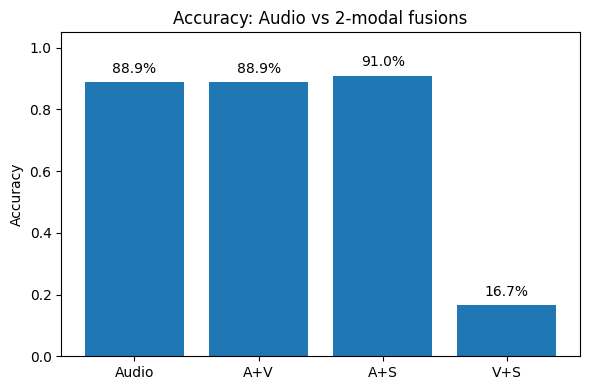

 Accuracy bar plot saved to outputs/fusion_2D_vs_3D/acc_bar_2modal.png


In [29]:


# Accuracy bar plot 
plt.figure(figsize=(6, 4))
bars = plt.bar(summary["method"], summary["accuracy"])
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.title("Accuracy: Audio vs 2-modal fusions")

#  Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.02,
        f"{height*100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()

# Save inside outputs folder, repo-friendly
out_path = BASE / "acc_bar_2modal.png"
plt.savefig(out_path, dpi=150)
plt.show()

print(f" Accuracy bar plot saved to {out_path}")

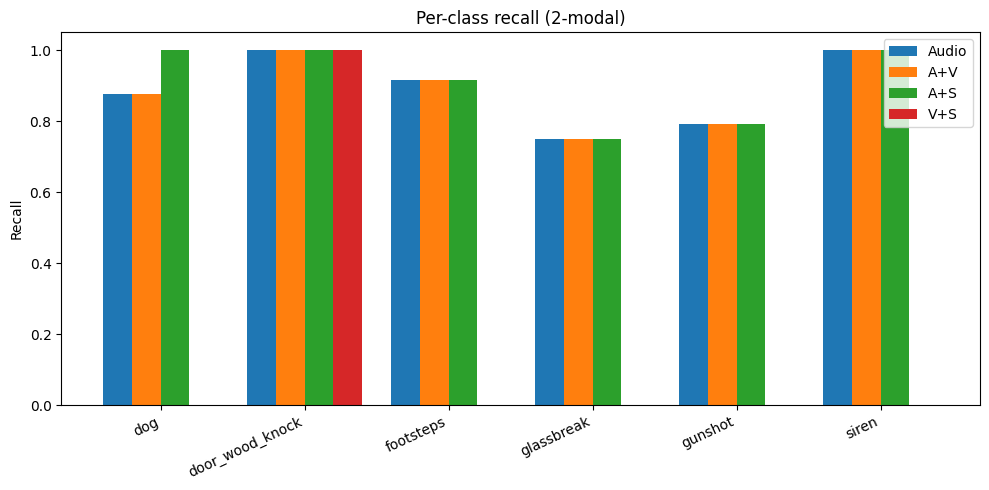

 Per-class recall plot saved to outputs/fusion_2D_vs_3D/per_class_recall_2modal.png


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

#  Helper: compute per-class recall 
def per_class_recall(y_true, y_pred, classes):
    rep = classification_report(
        y_true, y_pred, target_names=classes, output_dict=True, zero_division=0
    )
    return np.array([rep[c]["recall"] for c in classes])

# Collect recalls for all methods 
recalls = np.vstack([
    per_class_recall(y, audio_pred, CLASSES),
    per_class_recall(y, res_AV["pred"], CLASSES),
    per_class_recall(y, res_AS["pred"], CLASSES),
    per_class_recall(y, res_VS["pred"], CLASSES),
])
labels = ["Audio", "A+V", "A+S", "V+S"]

#  Plot 
plt.figure(figsize=(10,5))
x = np.arange(len(CLASSES))
width = 0.8 / len(labels)

for i, lab in enumerate(labels):
    plt.bar(x + i*width, recalls[i], width, label=lab)

plt.xticks(x + (len(labels)-1)*width/2, CLASSES, rotation=25, ha='right')
plt.ylim(0,1.05)
plt.ylabel("Recall")
plt.title("Per-class recall (2-modal)")
plt.legend()
plt.tight_layout()

# Save inside repo outputs folder
out_path = BASE / "per_class_recall_2modal.png"
plt.savefig(out_path, dpi=150)
plt.show()

print(f" Per-class recall plot saved to {out_path}")

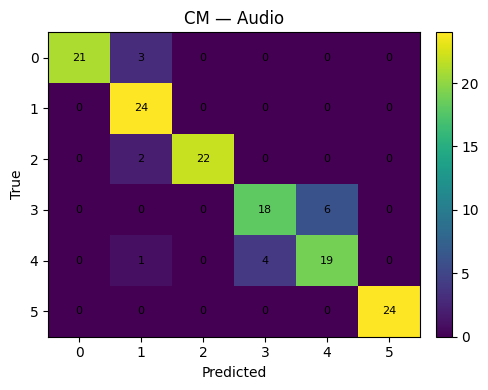

 Saved confusion matrix: outputs/fusion_2D_vs_3D/cm_audio.png


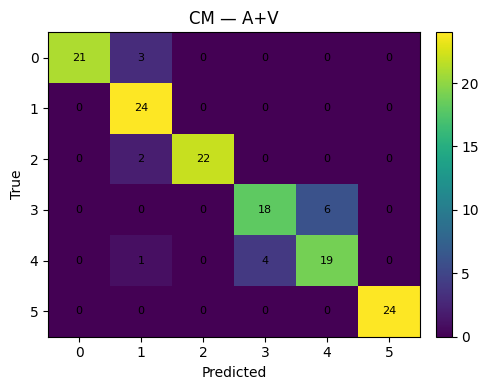

 Saved confusion matrix: outputs/fusion_2D_vs_3D/cm_AplusV.png


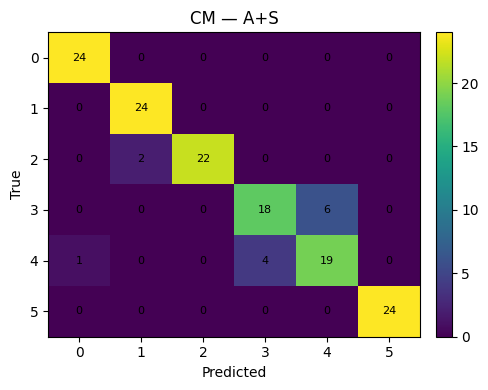

 Saved confusion matrix: outputs/fusion_2D_vs_3D/cm_AplusS.png


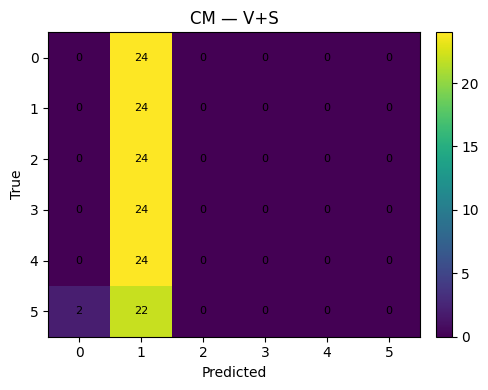

 Saved confusion matrix: outputs/fusion_2D_vs_3D/cm_VplusS.png
Confusion matrices of 2-modal fusion models saved


In [33]:


# Confusion matrix plotting helper
def plot_cm(y_true, y_pred, title, out_path):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(CLASSES)))
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest", aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(np.arange(len(CLASSES)), range(len(CLASSES)))
    plt.yticks(np.arange(len(CLASSES)), range(len(CLASSES)))
    
    # numbers inside each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=8)
    
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f" Saved confusion matrix: {out_path}")

# Save all confusion matrices 
plot_cm(y, audio_pred,     "CM — Audio", BASE / "cm_audio.png")
plot_cm(y, res_AV["pred"], "CM — A+V",   BASE / "cm_AplusV.png")
plot_cm(y, res_AS["pred"], "CM — A+S",   BASE / "cm_AplusS.png")
plot_cm(y, res_VS["pred"], "CM — V+S",   BASE / "cm_VplusS.png")

print("Confusion matrices of 2-modal fusion models saved")

<h2> PART -3   3 -MODAL WEIGHTED + META + VISUALS </h2>

In [31]:


#  Repo-friendly paths ---
BASE = Path("outputs/fusion_2D_vs_3D")   # where A.csv, V.csv, S.csv live
CLASSES = ["dog", "door_wood_knock", "footsteps", "glassbreak", "gunshot", "siren"]

# Load data
A_df = pd.read_csv(BASE / "A.csv")
y = A_df["y"].to_numpy(int)
A = A_df.drop(columns=["y"]).to_numpy(float)
V = pd.read_csv(BASE / "V.csv").to_numpy(float)
S = pd.read_csv(BASE / "S.csv").to_numpy(float)

def normalize_rows(p):
    s = p.sum(axis=1, keepdims=True)
    s[s == 0] = 1.0
    return p / s

# 3-modal grid search (weighted)
def best_weighted_3modal(A, V, S, y, step=0.02):
    best = {"acc": -1}
    ws = np.round(np.arange(0, 0.5 + 1e-9, step), 2)  # search V and S weights in [0, 0.5]
    for wv in ws:
        for ws_ in ws:
            wa = 1.0 - wv - ws_
            if wa < 0:
                continue
            fused = normalize_rows(wa * A + wv * V + ws_ * S)
            pred = fused.argmax(axis=1)
            acc = accuracy_score(y, pred)
            if acc > best["acc"]:
                best = {"acc": acc, "wa": wa, "wv": wv, "ws": ws_, "pred": pred, "probs": fused}
    return best

baseline_pred = A.argmax(axis=1)
baseline_acc = accuracy_score(y, baseline_pred)

best_AVS = best_weighted_3modal(A, V, S, y)

# Save results
out_path = BASE / "best_3modal_weighted.csv"
pd.DataFrame(best_AVS["probs"], columns=[f"AVS_{c}" for c in CLASSES]) \
  .assign(true=y, pred=best_AVS["pred"], wa=best_AVS["wa"], wv=best_AVS["wv"], ws=best_AVS["ws"]) \
  .to_csv(out_path, index=False)

print(f" 3-modal weighted acc={best_AVS['acc']:.4f} "
      f"(wa={best_AVS['wa']:.2f}, wv={best_AVS['wv']:.2f}, ws={best_AVS['ws']:.2f})")
print(classification_report(y, best_AVS["pred"], target_names=CLASSES, digits=4))
print(f" Saved: {out_path}")

 3-modal weighted acc=0.9097 (wa=0.68, wv=0.00, ws=0.32)
                 precision    recall  f1-score   support

            dog     0.9600    1.0000    0.9796        24
door_wood_knock     0.9231    1.0000    0.9600        24
      footsteps     1.0000    0.9167    0.9565        24
     glassbreak     0.8182    0.7500    0.7826        24
        gunshot     0.7600    0.7917    0.7755        24
          siren     1.0000    1.0000    1.0000        24

       accuracy                         0.9097       144
      macro avg     0.9102    0.9097    0.9090       144
   weighted avg     0.9102    0.9097    0.9090       144

 Saved: outputs/fusion_2D_vs_3D/best_3modal_weighted.csv


In [35]:


# --- Repo-friendly paths ---
BASE = Path("outputs/fusion_2D_vs_3D")  # where A.csv, V.csv, S.csv live
BASE.mkdir(parents=True, exist_ok=True)

# --- Load A, V, S (created earlier) ---
A_df = pd.read_csv(BASE / "A.csv")         # contains y column
y = A_df["y"].to_numpy(int)
A = A_df.drop(columns=["y"]).to_numpy(float)

V = pd.read_csv(BASE / "V.csv").to_numpy(float)
S = pd.read_csv(BASE / "S.csv").to_numpy(float)

# sanity check: all have same number of rows
assert A.shape[0] == V.shape[0] == S.shape[0] == y.shape[0], "Row count mismatch among A,V,S,y."

# Baseline (audio-only) for reference
baseline_pred = A.argmax(axis=1)
baseline_acc  = accuracy_score(y, baseline_pred)

# --- Meta-classifier helpers ---
X_concat = np.hstack([A, V, S])

def cv_meta(X, y, clf, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, f1s = [], []
    for tr, te in skf.split(X, y):
        clf_ = clone(clf)        # fresh copy each fold
        clf_.fit(X[tr], y[tr])
        yhat = clf_.predict(X[te])
        accs.append(accuracy_score(y[te], yhat))
        f1s.append(f1_score(y[te], yhat, average="macro"))
    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(f1s))

# Models
logreg = LogisticRegression(max_iter=2000, multi_class="multinomial", solver="lbfgs")
rf     = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced_subsample")

# Cross-validated metrics
lr_acc, lr_std, lr_f1 = cv_meta(X_concat, y, logreg)
rf_acc, rf_std, rf_f1 = cv_meta(X_concat, y, rf)

# Save summary
summary3 = pd.DataFrame([{
    "audio_only_acc": baseline_acc,
    "meta_logreg_acc_mean": lr_acc, "meta_logreg_acc_std": lr_std, "meta_logreg_f1": lr_f1,
    "meta_rf_acc_mean": rf_acc,     "meta_rf_acc_std": rf_std,     "meta_rf_f1": rf_f1,
}])
out_path = BASE / "fusion_3modal_summary.csv"
summary3.to_csv(out_path, index=False)

print(summary3.T.rename(columns={0: "value"}))
print(f"Saved: {out_path}")

/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py

                         value
audio_only_acc        0.888889
meta_logreg_acc_mean  0.896059
meta_logreg_acc_std   0.048426
meta_logreg_f1        0.895945
meta_rf_acc_mean      0.909852
meta_rf_acc_std       0.059961
meta_rf_f1            0.909110
Saved: outputs/fusion_2D_vs_3D/fusion_3modal_summary.csv


In [36]:


# Meta-classifier (LogReg + RF) 
X_concat = np.hstack([A,V,S])

def cv_meta(X, y, clf, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, f1s = [], []
    for tr, te in skf.split(X, y):
        clf_ = clone(clf)   # avoid state carryover
        clf_.fit(X[tr], y[tr])
        yhat = clf_.predict(X[te])
        accs.append(accuracy_score(y[te], yhat))
        f1s.append(f1_score(y[te], yhat, average="macro"))
    return np.mean(accs), np.std(accs), np.mean(f1s)

logreg = LogisticRegression(max_iter=2000, multi_class="multinomial", solver="lbfgs")
rf     = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced_subsample")

lr_acc, lr_std, lr_f1 = cv_meta(X_concat, y, logreg)
rf_acc, rf_std, rf_f1 = cv_meta(X_concat, y, rf)

summary3 = pd.DataFrame([{
    "audio_only_acc": baseline_acc,
    "weighted_3modal_acc": best_AVS["acc"],
    "meta_logreg_acc_mean": lr_acc, "meta_logreg_acc_std": lr_std, "meta_logreg_f1": lr_f1,
    "meta_rf_acc_mean": rf_acc,     "meta_rf_acc_std": rf_std,     "meta_rf_f1": rf_f1,
}])

summary3.to_csv(f"{BASE}/fusion_3modal_summary.csv", index=False)
print(summary3.T.rename(columns={0:"value"}))

/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/shid_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py

                         value
audio_only_acc        0.888889
weighted_3modal_acc   0.909722
meta_logreg_acc_mean  0.896059
meta_logreg_acc_std   0.048426
meta_logreg_f1        0.895945
meta_rf_acc_mean      0.909852
meta_rf_acc_std       0.059961
meta_rf_f1            0.909110


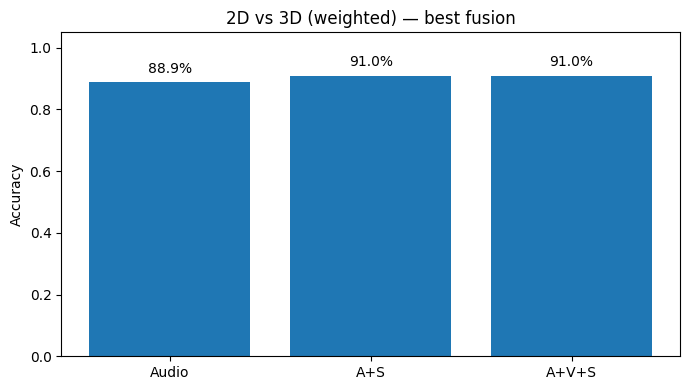

In [37]:
from pathlib import Path

# base
BASE = Path("outputs/fusion_2D_vs_3D")

# Load 2-modal summary
two_modal = pd.read_csv(BASE / "fusion_2modal_summary.csv")
best_2mod = two_modal.loc[two_modal["method"] != "Audio"].sort_values("accuracy", ascending=False).iloc[0]

# Plot
plt.figure(figsize=(7, 4))
names = ["Audio", best_2mod["method"], "A+V+S"]
accs = [baseline_acc, best_2mod["accuracy"], best_AVS["acc"]]

bars = plt.bar(names, accs)
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.title("2D vs 3D (weighted) — best fusion")

# Annotate
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02,
             f"{height*100:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(BASE / "bar_2D_vs_3D_best.png", dpi=150)
plt.show()

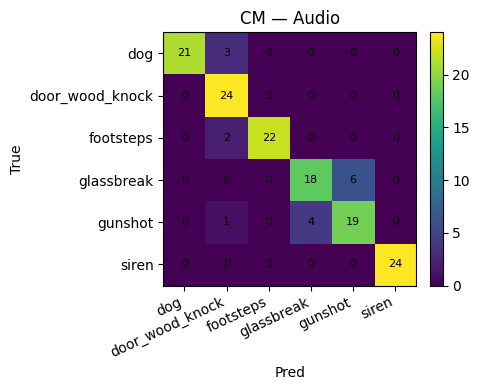

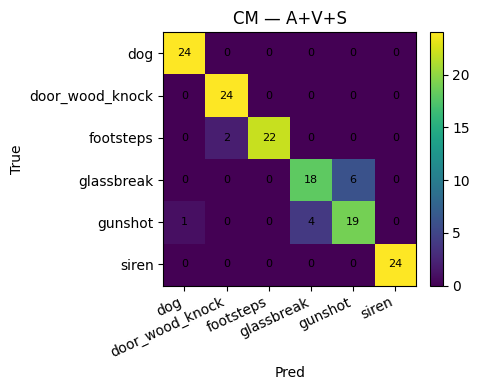

Fusion comparisons and metrics saved to: outputs/fusion_2D_vs_3D


In [38]:
from pathlib import Path

# Base output folder
BASE = Path("outputs/fusion_2D_vs_3D")

# Confusion matrices 
def plot_cm(true, pred, title, out_path):
    cm = confusion_matrix(true, pred, labels=np.arange(len(CLASSES)))
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(CLASSES)))
    ax.set_xticklabels(CLASSES, rotation=25, ha='right')
    ax.set_yticks(np.arange(len(CLASSES)))
    ax.set_yticklabels(CLASSES)
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")
    ax.set_title(title)

    # annotate each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.show()

# Save confusion matrices
plot_cm(y, baseline_pred,    "CM — Audio",  BASE / "cm_audio_again.png")
plot_cm(y, best_AVS["pred"], "CM — A+V+S", BASE / "cm_3modal_weighted.png")

print("Fusion comparisons and metrics saved to:", BASE)